# An Enhanced Hand Gesture Recognition System

In [ ]:
# Install kaggle. Make sure you have a JSON file from the dataset you want to analyze.
!pip install -q kaggle
from google.colab import files

files.upload()

In [ ]:
# Unzip dataset
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
# Import everything we need for the project
# ! pip install tabulate #install tables (included)

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import (
    train_test_split,
)  # Helps with organizing data for training
from sklearn.metrics import (
    confusion_matrix,
)  # Helps present results as a confusion-matrix
from collections import defaultdict
from google.colab import drive

# Import of keras model and hidden layers for our convolutional network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler

from sklearn.metrics import classification_report
import numpy as np

from sklearn.metrics import confusion_matrix
from tabulate import tabulate


print(tf.__version__)

2.15.0


In [ ]:
# Set up a dictionary to count images per letter
image_count_per_letter = defaultdict(int)
# Define the maximum number of images per letter
max_images_per_letter = 100

imagepaths = []
# Set the start directory
start_directory = "./asl_alphabet_train"

# List to store the names of subdirectories
subdirectories = []

# Subdirectories to skip
skip_dirs = {"del", "nothing", "space"}

# Go through all the files and subdirectories inside 'asl_alphabet_train'
for root, dirs, files in os.walk(start_directory, topdown=False):
    for dir in dirs:
        if dir in skip_dirs:
            continue  # Skip the specified subdirectories
        subdirectory = os.path.join(root, dir)
        subdirectories.append(subdirectory)
    for name in files:
        if name.lower().endswith(
            ".jpg"
        ):  # Check the extension to be 'jpg', case-insensitive
            # Extract the letter from the file path
            letter = os.path.basename(root)
            if letter in skip_dirs:
                continue  # Skip files in the specified subdirectories
            # Only proceed if we haven't already collected max_images_per_letter for this letter
            if image_count_per_letter[letter] < max_images_per_letter:
                path = os.path.join(root, name)
                imagepaths.append(path)
                image_count_per_letter[letter] += 1
                # If we've reached the limit for this letter, no need to continue checking
                if image_count_per_letter[letter] == max_images_per_letter:
                    continue

print("Number of image paths:", len(imagepaths))
print(f"Collected image paths, with up to {max_images_per_letter} images per letter.")

# Print the subdirectories
print("Subdirectories found:")
for subdir in subdirectories:
    print(subdir)

Number of image paths: 2600
Collected image paths, with up to 100 images per letter.
Subdirectories found:
./asl_alphabet_train/asl_alphabet_train/S
./asl_alphabet_train/asl_alphabet_train/B
./asl_alphabet_train/asl_alphabet_train/N
./asl_alphabet_train/asl_alphabet_train/G
./asl_alphabet_train/asl_alphabet_train/V
./asl_alphabet_train/asl_alphabet_train/D
./asl_alphabet_train/asl_alphabet_train/Q
./asl_alphabet_train/asl_alphabet_train/P
./asl_alphabet_train/asl_alphabet_train/E
./asl_alphabet_train/asl_alphabet_train/I
./asl_alphabet_train/asl_alphabet_train/A
./asl_alphabet_train/asl_alphabet_train/K
./asl_alphabet_train/asl_alphabet_train/T
./asl_alphabet_train/asl_alphabet_train/W
./asl_alphabet_train/asl_alphabet_train/Z
./asl_alphabet_train/asl_alphabet_train/R
./asl_alphabet_train/asl_alphabet_train/C
./asl_alphabet_train/asl_alphabet_train/H
./asl_alphabet_train/asl_alphabet_train/O
./asl_alphabet_train/asl_alphabet_train/L
./asl_alphabet_train/asl_alphabet_train/Y
./asl_alpha

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


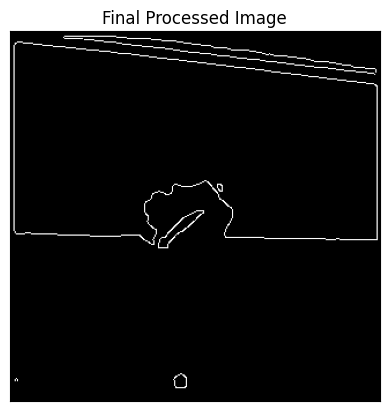

In [ ]:
# This section will output one image and show the final processed picture
def process_and_plot_final_image(path):
    # Load the image
    image = cv2.imread(path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")

    # Resize the image
    resized_image = cv2.resize(image, (320, 320))

    # Convert to grayscale
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply Otsu's thresholding
    _, thresholded = cv2.threshold(
        blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # Canny edge detection
    final_image = cv2.Canny(thresholded, 50, 150)

    # Normalize the final image
    normalized_image = final_image / 255.0

    # Display the final image
    plt.imshow(normalized_image, cmap="gray")
    plt.title("Final Processed Image")
    plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()


# Call the function with the path to your image
process_and_plot_final_image(imagepaths[2])

In [ ]:
print(imagepaths[2])  # debugging purpose

./asl_alphabet_train/asl_alphabet_train/S/S733.jpg


In [ ]:
# Apply computer vision algos to all pictures in dataset
X = []  # Image data
y = []  # Labels
skipped_images = 0

# Define the desired image size
desired_size = (320, 320)

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
    # Load the image
    image = cv2.imread(path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")

    # Resize the image to the desired size
    resized_image = cv2.resize(image, desired_size)

    # Convert to grayscale
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply Otsu's thresholding
    _, thresholded = cv2.threshold(
        blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # Canny edge detection
    final_image = cv2.Canny(thresholded, 50, 150)

    # Add the processed image to the dataset
    X.append(final_image)

    # Process the label in the image path
    filename = os.path.basename(path)
    label_part = filename.split(".")[0]

    label_mapping = {
        "A": 0,
        "B": 1,
        "C": 2,
        "D": 3,
        "E": 4,
        "F": 5,
        "G": 6,
        "H": 7,
        "I": 8,
        "J": 9,
        "K": 10,
        "L": 11,
        "M": 12,
        "N": 13,
        "O": 14,
        "P": 15,
        "Q": 16,
        "R": 17,
        "S": 18,
        "T": 19,
        "U": 20,
        "V": 21,
        "W": 22,
        "X": 23,
        "Y": 24,
        "Z": 25,
    }

    if len(label_part) > 1 and label_part[1:].isdigit():
        label_char = label_part[0]
        label = label_mapping.get(label_char, -1)
    else:
        label = label_mapping.get(label_part, -1)

    y.append(label)

# Convert X and y into np.array to speed up future processing
X = np.array(X, dtype="uint8")
X = X / 255.0  # Normalize pixel values to be between 0 and 1
X = X.reshape(
    len(imagepaths) - skipped_images, desired_size[0], desired_size[1], 1
)  # Adjust for 1 channel

y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

Images loaded:  2600
Labels loaded:  2600


In [ ]:
ts = 0.3  # Define the percentage of images for testing

# Specify the 'stratify' parameter
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, random_state=42, stratify=y
)

In [ ]:
# Machine Learning Model


# Define a learning rate schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 30:
        lr *= 0.5
    if epoch > 60:
        lr *= 0.5
    return lr


# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Create and compile the model with corrected input shape
model = Sequential(
    [
        Conv2D(
            32, (5, 5), activation="relu", input_shape=(320, 320, 1)
        ),  # Adjusted input shape
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(
            26, activation="softmax"
        ),  # Adjust the number of units to match the number of classes
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Filter out samples with '-1' labels
valid_train_samples = y_train != -1
valid_test_samples = y_test != -1

X_train_filtered = X_train[valid_train_samples]
y_train_filtered = y_train[valid_train_samples]

X_test_filtered = X_test[valid_test_samples]
y_test_filtered = y_test[valid_test_samples]

# Train the model with the filtered datasets and the learning rate scheduler
model.fit(
    X_train_filtered,
    y_train_filtered,
    epochs=20,
    batch_size=64,
    verbose=2,
    validation_data=(X_test_filtered, y_test_filtered),
    callbacks=[lr_scheduler],
)

Epoch 1/20
29/29 - 110s - loss: 2.9861 - accuracy: 0.1456 - val_loss: 2.3897 - val_accuracy: 0.3141 - lr: 0.0010 - 110s/epoch - 4s/step
Epoch 2/20
29/29 - 108s - loss: 1.5137 - accuracy: 0.5423 - val_loss: 1.7917 - val_accuracy: 0.4962 - lr: 0.0010 - 108s/epoch - 4s/step
Epoch 3/20
29/29 - 109s - loss: 0.3682 - accuracy: 0.8967 - val_loss: 1.9742 - val_accuracy: 0.5372 - lr: 0.0010 - 109s/epoch - 4s/step
Epoch 4/20
29/29 - 109s - loss: 0.0796 - accuracy: 0.9802 - val_loss: 2.9627 - val_accuracy: 0.5192 - lr: 0.0010 - 109s/epoch - 4s/step
Epoch 5/20
29/29 - 108s - loss: 0.0424 - accuracy: 0.9901 - val_loss: 2.5298 - val_accuracy: 0.5410 - lr: 0.0010 - 108s/epoch - 4s/step
Epoch 6/20
29/29 - 108s - loss: 0.0148 - accuracy: 0.9973 - val_loss: 2.7255 - val_accuracy: 0.5590 - lr: 0.0010 - 108s/epoch - 4s/step
Epoch 7/20
29/29 - 107s - loss: 0.0035 - accuracy: 0.9995 - val_loss: 2.9186 - val_accuracy: 0.5692 - lr: 0.0010 - 107s/epoch - 4s/step
Epoch 8/20
29/29 - 108s - loss: 0.0011 - accurac

In [ ]:
# Save entire model to a HDF5 file
model.save("projec_ASLrecognition.keras")

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate a classification report
report = classification_report(y_test, y_pred_classes, target_names=class_names)

print("Classification Report: \n", report)

25/25 [==============================] - 13s 502ms/step
Classification Report: 
               precision    recall  f1-score   support

           A       0.58      0.63      0.60        30
           B       0.59      0.53      0.56        30
           C       0.59      0.67      0.62        30
           D       0.64      0.47      0.54        30
           E       0.52      0.50      0.51        30
           F       0.74      0.83      0.78        30
           G       0.75      0.60      0.67        30
           H       0.71      0.67      0.69        30
           I       0.60      0.60      0.60        30
           J       0.66      0.70      0.68        30
           K       0.57      0.67      0.62        30
           L       0.57      0.80      0.67        30
           M       0.65      0.57      0.61        30
           N       0.52      0.53      0.52        30
           O       0.50      0.40      0.44        30
           P       0.57      0.57      0.57        30


In [ ]:
predictions = model.predict(X_test)  # Make predictions towards the test set

25/25 [==============================] - 12s 485ms/step


In [ ]:
np.argmax(predictions[0]), y_test[0]  # If same, got it right

(8, 8)

In [ ]:
# Function to plot images and labels for validation purposes
def validate_26_images(predictions_array, true_label_array, img_array):
    # Array for pretty printing and then figure size
    class_names = [
        "A",
        "B",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "J",
        "K",
        "L",
        "M",
        "N",
        "O",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "U",
        "V",
        "W",
        "X",
        "Y",
        "Z",
    ]
    plt.figure(figsize=(15, 15))

    for i in range(1, 27):
        # Just assigning variables
        prediction = predictions_array[i]
        true_label = true_label_array[i]
        img = img_array[i]

        # Plot in a good way
        plt.subplot(
            7, 4, i
        )  # You may need to adjust the layout based on your preference
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap=plt.cm.binary)

        predicted_label = np.argmax(
            prediction
        )  # Get index of the predicted label from prediction

        # Change color of title based on good prediction or not
        if predicted_label == true_label:
            color = "blue"
        else:
            color = "red"

        plt.xlabel(
            "Predicted: {} {:2.0f}% (True: {})".format(
                class_names[predicted_label],
                100 * np.max(prediction),
                class_names[true_label],
            ),
            color=color,
        )
    plt.show()

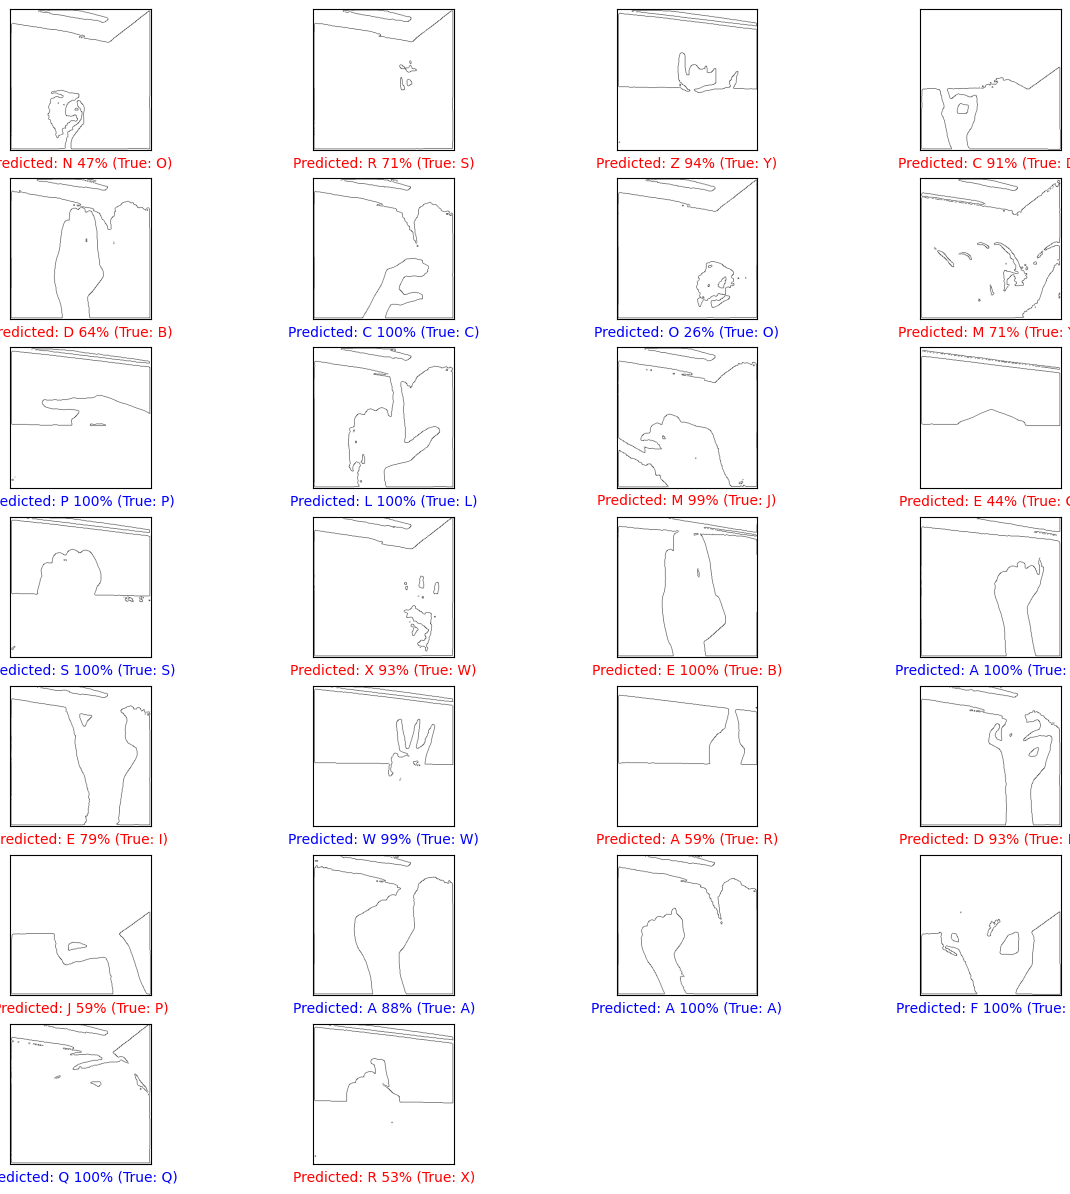

In [ ]:
validate_26_images(predictions, y_test, X_test)

In [ ]:
y_pred = np.argmax(
    predictions, axis=1
)  # Transform predictions into 1-D array with label number

In [ ]:
# Assuming y_test contains the true labels and y_pred contains the predicted labels
confusion = confusion_matrix(y_test, y_pred)

# Define the alphabet labels
class_names = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
]

# Create a DataFrame for the confusion matrix with labeled columns and indices
confusion_df = pd.DataFrame(
    confusion,
    columns=[f"Predicted {class_name}" for class_name in class_names],
    index=[f"Actual {class_name}" for class_name in class_names],
)

# Display the confusion matrix as a formatted table
print(tabulate(confusion_df, headers="keys", tablefmt="fancy_grid"))

╒══════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│          │   Predicted A │   Predicted B │   Predicted C │   Predicted D │   Predicted E │   Predicted F │   Predicted G │   Predicted H │   Predicted I │   Predicted J │   Predicted K │   Predicted L │   Predicted M │   Predicted N │   Predicted O │   Predicted P │   Predicted Q │   Predicted R │   Predicted S │   Predicted T │   Predicted U │   Predicted V │   Predicted W │   Predicted X │   Predicted Y │   Predicted Z │
╞══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪══